In [4]:
import os.path
import pandas as pd
import numpy as np
import time
from datetime import timedelta
import tensorflow as tf
import json

from loadData import loadData, convertToBatches
inputDir = "GEFCom2012/"
import logging
__version__ = "1.0.0"
logging.basicConfig(filename='example.log',level=logging.DEBUG)
logger = logging.getLogger(__name__)

In [29]:
class RNN(object):
    """Recursive Neural Network"""


    def __init__(self, maxGradient, batchSize, timeSteps, nHorizons, inputSize, nHiddenUnits, nLayers):
        self.maxGradient = maxGradient
        self.nLayers = nLayers
        self.timeSteps = timeSteps
        self.nHorizons = nHorizons
        self.inputSize = inputSize
        self.batchSize = batchSize
        self.nHiddenUnits = nHiddenUnits
        
        with tf.name_scope("Parameters"):
            self.learningRate = tf.placeholder(tf.float32, name="learningRate")
            self.keepProbability = tf.placeholder(tf.float32, name="keepProbability")

        with tf.name_scope("Input"):
            self.input = tf.placeholder(tf.float32, shape=(batchSize, timeSteps, inputSize), name="input")
            self.targets = tf.placeholder(tf.float32, shape=(batchSize, timeSteps, nHorizons), name="targets")
            self.init = tf.placeholder(tf.float32, shape=(), name="init")
        #Declare the CNN structure here!
        #with tf.name_scope("Embedding"):
        #    self.embedding = tf.Variable(tf.random_uniform((inputSize, hidden_units), -self.init, self.init),
        #                                 dtype=tf.float32,
        #                                 name="embedding")
        #    self.w = tf.get_variable("w", (inputSize, hidden_units))
        #    self.b = tf.get_variable("b", inputSize)
            
        #    self.embedded_input = tf.matmul(self.input, self.w) + self.b

        with tf.name_scope("RNN"):
            cell = tf.nn.rnn_cell.LSTMCell(nHiddenUnits, state_is_tuple=True)
            cell = tf.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob=self.keepProbability)
            rnn_layers = tf.nn.rnn_cell.MultiRNNCell([cell] * nLayers, state_is_tuple=True)
            self.resetState = rnn_layers.zero_state(batchSize, dtype=tf.float32)
            state_placeholder = tf.placeholder(tf.float32, [nLayers, 2, batchSize, nHiddenUnits])
            #Unpack the state_placeholder into tuple to use with tensorflow native RNN API
            l = tf.unpack(state_placeholder, axis=0)
            self.state = tuple(
                                [tf.nn.rnn_cell.LSTMStateTuple(l[idx][0], l[idx][1]) 
                                for idx in range(nLayers)]
                              )
            
            #print(self.reset_state)
            #self.state = (tf.placeholder(tf.float32, shape=(batchSize, nHidden) , "state"))
            self.outputs, self.nextState = tf.nn.dynamic_rnn(rnn_layers, self.input, time_major=True,
                                                              initial_state=self.state)

        with tf.name_scope("Cost"):
            # Concatenate all the batches into a single row.
            self.flattenedOutputs = tf.reshape(self.outputs, (-1, nHiddenUnits),
                                                name="flattenedOutputs")
            # Project the outputs onto the vocabulary.
            self.w = tf.get_variable("w", (nHiddenUnits, nHorizons))
            self.b = tf.get_variable("b", nHorizons)
            self.predicted = tf.matmul(self.flattenedOutputs, self.w) + self.b
            self.flattenedTargets = tf.reshape(self.targets, (-1, nHorizons), name = "flattenedTargets")
            # Compare predictions to labels.
            self.loss = tf.sqrt(tf.reduce_mean(tf.square(tf.sub(self.flattenedTargets, self.predicted))))
            self.cost = tf.div(tf.reduce_sum(self.loss), batchSize, name="cost")

        with tf.name_scope("Train"):
            #self.validation_perplexity = tf.Variable(dtype=tf.float32, initial_value=float("inf"), trainable=False,
            #                                         name="validation_perplexity")
            #tf.scalar_summary(self.validation_perplexity.op.name, self.validation_perplexity)
            #self.training_epoch_perplexity = tf.Variable(dtype=tf.float32, initial_value=float("inf"), trainable=False,
            #                                             name="training_epoch_perplexity")
            #tf.scalar_summary(self.training_epoch_perplexity.op.name, self.training_epoch_perplexity)
            self.iteration = tf.Variable(0, dtype=tf.int64, name="iteration", trainable=False)
            self.gradients, _ = tf.clip_by_global_norm(tf.gradients(self.cost, tf.trainable_variables()),
                                                       maxGradient, name="clipGradients")
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=self.learningRate)
            self.trainStep = optimizer.apply_gradients(zip(self.gradients, tf.trainable_variables()),
                                                        name="trainStep",
                                                        global_step=self.iteration)

        self.initialize = tf.initialize_all_variables()
        self.summary = tf.merge_all_summaries()

    @property
    def batch_size(self):
        return self.input.get_shape()[0].value

    @property
    def time_steps(self):
        return self.input.get_shape()[1].value

    @property
    def vocabulary_size(self):
        return self.embedding.get_shape()[0].value

    @property
    def hidden_units(self):
        return self.embedding.get_shape()[1].value

    def train(self, session, init, ts, parameters, exitCriteria, validation, loggingInterval, directories):
        epoch = 1
        iteration = 0
        state = None
        trainingSet = convertToBatches(ts, self.timeSteps, self.batchSize, self.nHorizons)
        summary = self.summaryWriter(directories.summary, session)
        session.run(self.initialize, feed_dict={self.init: init})
        try:
            # Enumerate over the training set until exit criteria are met.
            tsFit = []
            tsTarget = []
            lastState = None
            while True:
                if (exitCriteria.maxEpochs is not None) and (epoch > exitCriteria.maxEpochs):
                    lastState = state
                    raise StopTrainingException()
                epochCost = epochIteration = 0
                #Reset state after every epoch
                state = session.run(self.resetState)
                # Enumerate over a single epoch of the training set.
                for xs, ys in trainingSet:
                    _, cost, state, iteration, predicted = session.run(
                        [self.trainStep, self.cost, self.nextState, self.iteration, self.predicted],
                        feed_dict={
                            self.input: xs,
                            self.targets: ys,
                            self.state: state,
                            self.learningRate: parameters.learningRate,
                            self.keepProbability: parameters.keepProbability
                        })
                    if (epoch == exitCriteria.maxEpochs):
                        tsFit.append(predicted)
                        tsTarget.append(ys)
                        
                    epochCost += cost
                    epochIteration += self.timeSteps
                    #if self._interval(iteration, loggingInterval):
                        #logger.info("Epoch %d, Iteration %d: epoch training perplexity %0.4f" %
                    #                (epoch, iteration, self.perplexity(epochCost, epochIteration)))
                    #if validation is not None and self._interval(iteration, validation.interval):
                    #    validation_perplexity = self.test(session, validation.validation_set)
                        #self.store_validation_perplexity(session, summary, iteration, validation_perplexity)
                        #self.store_rmse(session, summary, iteration, self.rmse)
                    logger.info("Epoch %d, Iteration %d: training loss %0.4f" %
                                (epoch, iteration, cost))

                #self.store_trainingEpochRMSE(session, summary, iteration, epoch_cost)
                logger.info("---Epoch %d, Iteration %d: epoch loss %0.4f" % (epoch, iteration, epochCost))

                epoch += 1
                if (exitCriteria.maxIterations is not None) and (iteration > exitCriteria.maxIterations):
                    raise StopTrainingException()
        except (StopTrainingException, KeyboardInterrupt):
            pass
        logger.info("Stop training at epoch %d, iteration %d" % (epoch, iteration))
        summary.close()
        if directories.model is not None:
            modelFileName = self._modelFile(directories.model)
            tf.train.Saver().save(session, modelFileName)
            self._writeModelParameters(directories.model)
            logger.info("Saved model in %s " % directories.model)
            
        tsFit = np.reshape(np.asarray(tsFit), (-1, nHorizons))
        tsTarget = np.reshape(np.asarray(tsTarget), (-1, nHorizons))
        return (tsTarget, tsFit, lastState)

    def _writeModelParameters(self, modelDirectory):
        parameters = {
            "maxGradient": self.maxGradient,
            "batchSize": self.batchSize,
            "timeSteps": self.timeSteps,
            "inputSize": self.inputSize,
            "nHiddenUnits": self.nHiddenUnits,
            "nLayers": self.nLayers,
            "nHorizons": self.nHorizons
        }
        with open(self._parametersFile(modelDirectory), "w") as f:
            json.dump(parameters, f, indent=4)

    def predict(self, session, startState, tsTest):
        state = None
        testSet = convertToBatches(ts, self.timeSteps, self.batchSize, self.nHorizons, cutHead=False)
        tsPredicted = []
        tsTarget = []
        epoch_cost = 0
        state = startState
        for xs, ys in testSet:
            cost, state, predicted = session.run(
                [self.cost, self.nextState, self.predicted],
                feed_dict={
                    self.input: xs,
                    self.targets: ys,
                    self.state: state,
                    self.keepProbability: 1
                })
            epoch_cost += cost
            tsPredicted.append(predicted)
            tsTarget.append(ys)
        
        tsPredicted = np.reshape(np.asarray(tsPredicted), (-1, self.nHorizons))
        tsTarget = np.reshape(np.asarray(tsTarget), (-1, self.nHorizons))
        return (tsTarget, tsPredicted, epoch_cost)

    @staticmethod
    def _interval(iteration, interval):
        return interval is not None and iteration > 1 and iteration % interval == 0

    @staticmethod
    def perplexity(cost, iterations):
        return np.exp(cost / iterations)

    def store_validation_perplexity(self, session, summary, iteration, validation_perplexity):
        session.run(self.validation_perplexity.assign(validation_perplexity))
        summary.addSummary(session.run(self.summary), global_step=iteration)

    def store_training_epoch_perplexity(self, session, summary, iteration, training_perplexity):
        session.run(self.training_epoch_perplexity.assign(training_perplexity))
        summary.addSummary(session.run(self.summary), global_step=iteration)

    @staticmethod
    def summaryWriter(summaryDirectory, session):
        class NullSummaryWriter(object):
            def addSummary(self, *args, **kwargs):
                pass

            def flush(self):
                pass

            def close(self):
                pass

        if summaryDirectory is not None:
            return tf.train.SummaryWriter(summaryDirectory, session.graph)
        else:
            return NullSummaryWriter()

    @classmethod
    def restore(cls, session, modelDirectory):
        """
        Restore a previously trained model
        :param session: session into which to restore the model
        :type session: TensorFlow Session
        :param model_directory: directory to which the model was saved
        :type model_directory: str
        :return: trained model
        :rtype: RNN
        """
        with open(cls._parametersFile(modelDirectory)) as f:
            parameters = json.load(f)
        model = cls(parameters["maxGradient"],
                    parameters["batchSize"], parameters["timeSteps"], parameters["inputSize"],
                    parameters["nHiddenUnits"], parameters["nLayers"], parameters["nHorizons"])
        tf.train.Saver().restore(session, cls._modelFile(modelDirectory))
        return model

    @staticmethod
    def _parametersFile(modelDirectory):
        return os.path.join(modelDirectory, "parameters.json")

    @staticmethod
    def _modelFile(modelDirectory):
        return os.path.join(modelDirectory, "model")

class StopTrainingException(Exception):
    pass


# Objects used to group training parameters
class ExitCriteria(object):
    def __init__(self, maxIterations, maxEpochs):
        self.maxIterations = maxIterations
        self.maxEpochs = maxEpochs


class Parameters(object):
    def __init__(self, learningRate, keepProbability):
        self.learningRate = learningRate
        self.keepProbability = keepProbability


class Validation(object):
    def __init__(self, interval, validation_set):
        self.interval = interval
        self.validation_set = validation_set


class Directories(object):
    def __init__(self, model, summary):
        self.model = model
        self.summary = summary

In [30]:
modelDirectory = "GEFCom2012/Model"
summaryDirectory = "GEFCom2012/Model"
maxGradient = 1
timeSteps = 20
nHorizons = 24
batchSize = 20
nHiddenUnits = 200
nLayers = 2
init = 0.05
inputSize = 1
keepProbability = 0.5
maxEpochs=10
learningRate=1.0
maxIterations = 1000000
loggingInterval = 1

trainingDfs, completeDfs = loadData("GEFCom2012/", maxDataPoints = -1)
ts = trainingDfs[0][["zone.1"]].values
batches = convertToBatches(ts, timeSteps, batchSize, nHorizons)


ts = trainingDfs[0][["zone.1"]].values
tsTest = trainingDfs[0][["zone.1"]].values
tsTest = ts[len(ts):]
##Normalize ts
ts = (ts-ts.mean())/(ts.max()-ts.min())
if modelDirectory is None:
    logger.warn("Not saving a model.")
logger.info("Start Experiment")

# Run training.
start_time = time.time()
with tf.device('/gpu:0'):
    with tf.Graph().as_default():
        model = RNN(maxGradient = maxGradient, 
                    batchSize = batchSize, 
                    timeSteps = timeSteps, 
                    nHorizons = nHorizons, 
                    inputSize = inputSize, 
                    nHiddenUnits = nHiddenUnits, 
                    nLayers = nLayers)
        with tf.Session() as session:
            tsTarget, tsFit, lastState = model.train(session = session, 
                        init = init, 
                        ts = ts, 
                        parameters = Parameters(learningRate, keepProbability), 
                        exitCriteria = ExitCriteria(maxIterations, maxEpochs), 
                        validation = None, 
                        loggingInterval = loggingInterval, 
                        directories = Directories(modelDirectory, summaryDirectory))
logger.info("Total training time %s" % timedelta(seconds=(time.time() - start_time)))



In [31]:
with tf.device('/gpu:0'):
    with tf.Graph().as_default():
        with tf.Session() as session:
            model = RNN.restore(session, modelDirectory)
            tsTarget, tsPredicted, epoch_cost = model.predict(session = session,
                                                              startState = lastState, 
                                                              tsTest = tsTest)

NotFoundError: Tensor name "RNN/MultiRNNCell/Cell10/LSTMCell/B" not found in checkpoint files GEFCom2012/Model/model
	 [[Node: save/restore_slice_4 = RestoreSlice[dt=DT_FLOAT, preferred_shard=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save/Const_0, save/restore_slice_4/tensor_name, save/restore_slice_4/shape_and_slice)]]
	 [[Node: save/restore_slice_22/_21 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_18_save/restore_slice_22", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op u'save/restore_slice_4', defined at:
  File "/usr/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python2.7/dist-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-cf06cf933dc1>", line 4, in <module>
    model = RNN.restore(session, modelDirectory)
  File "<ipython-input-29-55b928cf5eb7>", line 249, in restore
    tf.train.Saver().restore(session, cls._modelFile(modelDirectory))
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/training/saver.py", line 1077, in __init__
    self.build()
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/training/saver.py", line 1106, in build
    restore_sequentially=self._restore_sequentially)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/training/saver.py", line 704, in build
    restore_sequentially, reshape)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/training/saver.py", line 441, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/training/saver.py", line 281, in restore_op
    preferred_shard=preferred_shard))
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/io_ops.py", line 204, in _restore_slice
    preferred_shard, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gen_io_ops.py", line 359, in _restore_slice
    preferred_shard=preferred_shard, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/op_def_library.py", line 749, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 2380, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 1298, in __init__
    self._traceback = _extract_stack()

NotFoundError (see above for traceback): Tensor name "RNN/MultiRNNCell/Cell10/LSTMCell/B" not found in checkpoint files GEFCom2012/Model/model
	 [[Node: save/restore_slice_4 = RestoreSlice[dt=DT_FLOAT, preferred_shard=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save/Const_0, save/restore_slice_4/tensor_name, save/restore_slice_4/shape_and_slice)]]
	 [[Node: save/restore_slice_22/_21 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_18_save/restore_slice_22", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]


0.103001198115


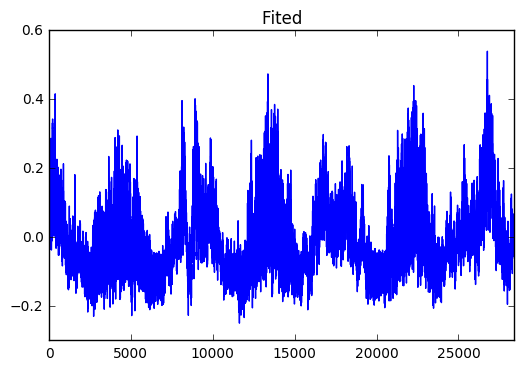

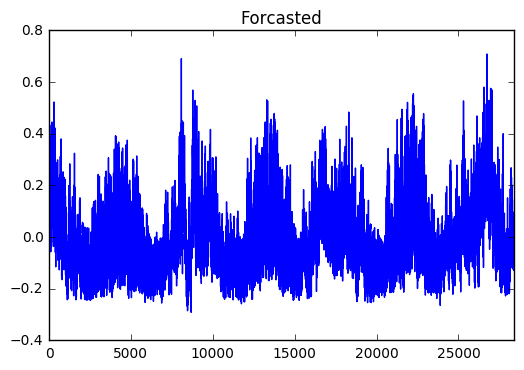

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline  
print np.sqrt(np.mean(np.square(tsTarget[:, 23]-tsFit[:, 23])))
x = pd.Series(tsFit[:, 23])
y = pd.Series(tsTarget[:, 23])
x.plot(title="Fited")
plt.figure()
y.plot(title="Forcasted")

In [24]:
model

In [ ]:
x.shape